# Code crunching

*by Pearu Peterson*

In developing software packages with a huge code base (e.g. pytorch), a considerable amount of time goes to 
building. Making a minor change to the source code may create a considerable gap to the development process due to the rebuild time of the package.

For optimal development cycle, one would want to predict the build time depending on the available computer resources as well as to understand what are the components that affect the build process most, for instance,
choosing build parameters or when planning to purchase a new build machine.

We track the memory usage and build time against the maximal number of jobs.

# The main takeaway

## nproc

`nproc` gives the number of processing units in the system and it is custom to use build command like:
```
make -j `nproc`
```
<font color=red>
DO NOT USE `nproc`! YOU'LL WASTE MEMORY WITH VERY LITTLE GAIN (unless #cores == #threads).
</font>

Instead, one should use the following:
```
export CORES_PER_SOCKET=`lscpu | grep 'Core(s) per socket' | awk '{print $NF}'`
export NUMBER_OF_SOCKETS=`lscpu | grep 'Socket(s)' | awk '{print $NF}'`
export NCORES=`echo "$CORES_PER_SOCKET * $NUMBER_OF_SOCKETS"| bc`

make -j $NCORES
```
It looks ugly but <font color=green>you'll achieve *optimal memory usage and minimal build time*</font>.


# Some Code Crunching Experiments


![qgpu-lscpu](qgpu-lscpu.png)

`nproc` -> 48

## Each software library has a *build fingerprint*

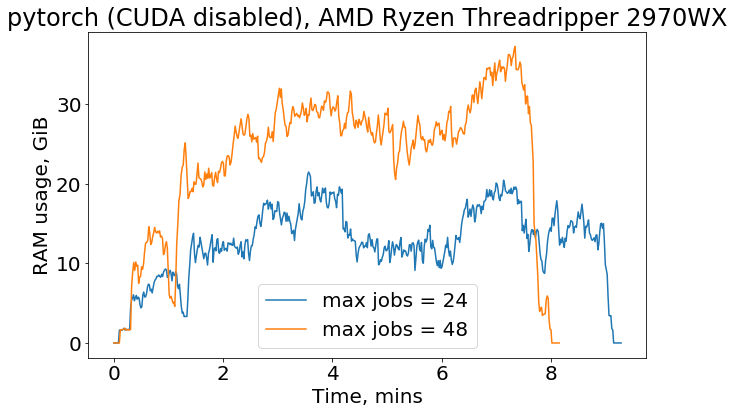

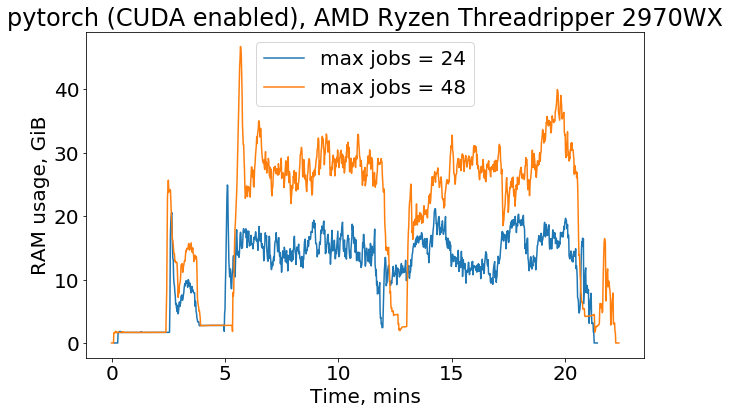

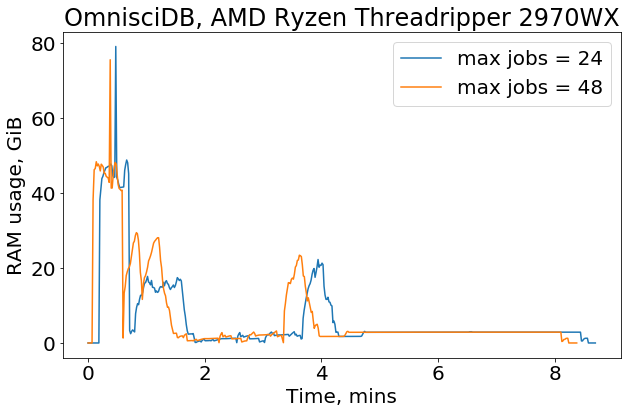

In [70]:
show_memusage([24, 48], 'pytorch_qgpu')
show_memusage([24, 48], 'pytorch_qgpu_cuda')
show_memusage([24, 48], 'omniscidb')

### Notes
1. At maximal number of used cores, 2 x more jobs has little effect to completition time but doubles memory usage
2. Different libraries have different build patterns
3. Here build pattern is defined as memory usage timeseries. It's roughly equivalent to the CPU usage timeseries.
4. Constant build pattern would be most optimal (keep CPU cores maximally occupied)


## Total build time is bounded by the total number of CPU cores

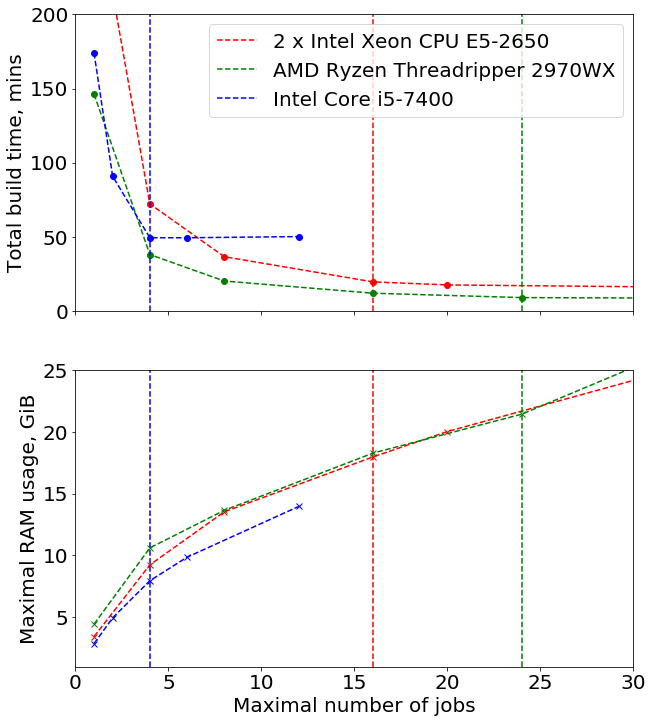

In [71]:
show_build_times('pytorch_asu', 'pytorch_qgpu', 'pytorch_swing',
                ylim1=dict(top=200, bottom=0), xlim1=dict(left=0, right=30),
                ylim2=dict(top=25))

## Build speedup from parallel compilation

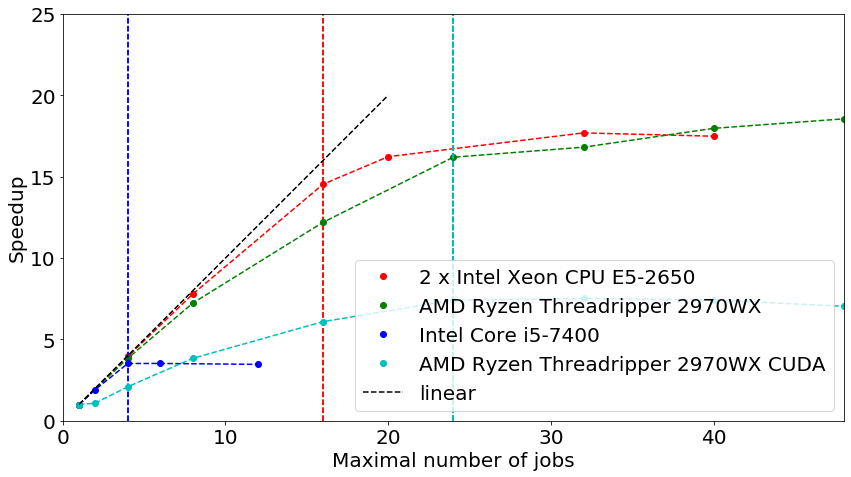

In [73]:
show_speedups('pytorch_asu', 'pytorch_qgpu', 'pytorch_swing', 'pytorch_qgpu_cuda',
                ylim=dict(top=25, bottom=0), xlim=dict(left=0, right=48))

## Conclusions

1. Be aware of NCORES and `ncores` in your build system. Use
```
make -j <NUMBER OF CORES>`             # where <NUMBER OF CORES> != nproc
```
2. Although Intel processors have less cores, these are faster and more efficient in multiprocessing than (price, launch year)-equivalent AMD processors

In [65]:
# build cmd:
#
#  git clean -xdf && time USE_CUDA=1 USE_MKLDNN=1 MAX_JOBS=<MAX_JOBS> python setup.py develop
#
# Results:
#   <MAX_JOBS>: <VSIZE time series>
vsize_data = dict(
    pytorch_asu={
        1: 'trac_max_memory-1569238157.log',
        4: 'trac_max_memory-1569257049.log',
        8: 'trac_max_memory-1569262275.log',
        16: 'trac_max_memory-1569236838.log',
        20: 'trac_max_memory-1569574663.log',
        32: 'trac_max_memory-1569255491.log',
        40: 'trac_max_memory-1569268505.log',
    },
    pytorch_swing={
        1: 'trac_max_memory-1569223246.log',
        2: 'trac_max_memory-1569243704.log',
        4: 'trac_max_memory-1569187820.log',
        6: 'trac_max_memory-1569190973.log',
        12: 'trac_max_memory-1569269438.log',
    },
    pytorch_qgpu={
        1: 'trac_max_memory-1569263730.log',
        4: 'trac_max_memory-1569256926.log',
        8: 'trac_max_memory-1569254768.log',
        16: 'trac_max_memory-1569253797.log',
        24: 'trac_max_memory-1569252465.log',
        32: 'trac_max_memory-1569262152.log',
        40: 'trac_max_memory-1569263043.log',
        48: 'trac_max_memory-1569253263.log',
        56: 'trac_max_memory-1569261609.log',
    },
    pytorch_qgpu_cuda={
        1: 'trac_max_memory-1569230498.log',
        2: 'trac_max_memory-1569243249.log',
        4: 'trac_max_memory-1569161637.log',
        8: 'trac_max_memory-1569185572.log',
        16: 'trac_max_memory-1569183435.log',
        24: 'trac_max_memory-1569166275.log',
        32: 'trac_max_memory-1569176978.log',
        40: 'trac_max_memory-1569178372.log',
        48: 'trac_max_memory-1569581916.log',
        56: 'trac_max_memory-1569180033.log',
        72: 'trac_max_memory-1569181848.log',
    },
    omniscidb={
        1: 'trac_max_memory-1569223871.log',
        4: 'trac_max_memory-1569191322.log',
        8: 'trac_max_memory-1569189941.log',
        16: 'trac_max_memory-1569189311.log',
        24: 'trac_max_memory-1569188701.log',
        32: 'trac_max_memory-1569190756.log',
        48: 'trac_max_memory-1569227731.log',
    }
)
#   <MAX_JOBS>: <real time to build pytorch>
build_time = dict(
    pytorch_asu={},
    pytorch_swing={
        1: 174*60+13,
        4: 49*60+38,
    },
    pytorch_qgpu={},
    pytorch_qgpu_cuda={
        4: 74*60+22, # this is AMD
        8: min(40*60+35, 40*60+31),
        12: 30*60+41,
        16: min(25*60+0, 25*60+34),
        20: 22*60+33,
        24: 20*60+25,
        32: 20*60+42,
        40: 20*60+59,
        48: 19*60+45,
        56: 21*60+2,
        64: 20*60+1,
        72: 21*60+11,
    },
    omniscidb={
        1: 38*60+23,
        4: 13*60+8,
        8: 10*60+12,
        16: 8*60+41,
        24: 8*60+22,
        32: 8*60+15,
        48: 8*60+9,
    }
)
params = dict(
    title = dict(
        pytorch_qgpu='pytorch (CUDA disabled), AMD Ryzen Threadripper 2970WX',
        pytorch_qgpu_cuda='pytorch (CUDA enabled), AMD Ryzen Threadripper 2970WX',
        omniscidb='OmnisciDB, AMD Ryzen Threadripper 2970WX',
        pytorch_swing='pytorch, Intel Core i5-7400',
        pytorch_asu='pytorch, 2 x Intel Xeon CPU E5-2650'
    ),
    cpu = dict(
        pytorch_qgpu='AMD Ryzen Threadripper 2970WX',
        pytorch_qgpu_cuda='AMD Ryzen Threadripper 2970WX',
        omniscidb='AMD Ryzen Threadripper 2970WX',
        pytorch_swing='Intel Core i5-7400',
        pytorch_asu='2 x Intel Xeon CPU E5-2650'
    ),
    ncores = dict(
        pytorch_qgpu=24,
        pytorch_qgpu_cuda=24,
        omniscidb=24,
        pytorch_swing=4,
        pytorch_asu=16,
    ),
    nproc = dict(
        pytorch_qgpu=24*2,
        pytorch_qgpu_cuda=24*2,
        omniscidb=24*2,
        pytorch_swing=4*1,
        pytorch_asu=16*2,
    ),
)

In [52]:
import os
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams.update({'font.size': 20})
def get_memusage(fn):
    t_lst, vsize_lst = [], []
    if os.path.isfile(fn):
        first_mn_vsise = None
        for line in open(fn).readlines():
            t, mn_vsise, vsize, mx_vsize = map(float, line.split())
            if first_mn_vsise is None:
                first_mn_vsise = mn_vsise
            t_lst.append(t / 60)
            vsize_lst.append((vsize - first_mn_vsise) / 1024**2)
    return t_lst, vsize_lst

def show_memusage(max_jobs_lst, title=''):
    for max_jobs, fn in vsize_data[title].items():
        if max_jobs not in max_jobs_lst or not os.path.isfile(fn):
            continue
        t_lst, vsize_lst = get_memusage(fn)
        i0, i1 = get_compilation(vsize_lst)
        t_lst = t_lst[max(0, i0-10): i1+10]
        vsize_lst = vsize_lst[max(0, i0-10): i1+10]
        plt.plot(t_lst, vsize_lst, label='max jobs = %s' % (max_jobs))
    plt.legend()
    plt.xlabel('Time, mins')
    plt.ylabel('RAM usage, GiB')
    if title:
        plt.title(params['title'][title])
    plt.show()
def get_compilation(lst):
    x = np.array(lst)
    i = np.where(x > x.min() + 0.5)[0]  # 1 is 1GiB
    return i[0], i[-1]
def show_build_time(title=''):
    jobs_lst, tm_lst = [], []
    max_vsize_lst, jobs2_lst = [], []
    all_max_jobs = list(build_time[title].keys())
    all_max_jobs.extend(vsize_data[title].keys())
    for max_jobs in sorted(set(all_max_jobs)):
        build_tm = build_time[title].get(max_jobs)
        #if build_tm is not None:
        #    jobs_lst.append(max_jobs)
        #    tm_lst.append(build_tm / 60)
        fn = vsize_data[title].get(max_jobs)
        if fn is not None and os.path.isfile(fn):
            t_lst, vsize_lst = get_memusage(fn)
            max_vsize_lst.append(max(vsize_lst))
            jobs2_lst.append(max_jobs)
            i0, i1 = get_compilation(vsize_lst)
            bld_time = t_lst[i1] - t_lst[i0]
            if build_tm is not None and abs(build_tm/60 - bld_time) > 1:
                print('Possibly inaccurate estimation of build time:',
                      fn, build_tm/60, bld_time)
            tm_lst.append(bld_time)
            jobs_lst.append(max_jobs)
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(jobs_lst, tm_lst, 'go')
    ax2.plot(jobs2_lst, max_vsize_lst, 'bx')
    ax1.plot(jobs_lst, tm_lst, 'g--')
    ax2.plot(jobs2_lst, max_vsize_lst, 'b--')
    ly = min(tm_lst)*0.25 + max(tm_lst)*0.75
    if params['ncores'][title] == params['nproc'][title]:
        ax1.axvline(params['ncores'][title], linestyle='--')
        ax1.text(params['ncores'][title],ly,'nproc == $NCORES',rotation=90)
    else:
        ax1.axvline(params['ncores'][title], linestyle='--')
        ax1.text(params['ncores'][title],ly,'$NCORES',rotation=90)
        ax1.axvline(params['nproc'][title], linestyle='--')
        ax1.text(params['nproc'][title],ly,'nproc',rotation=90)
    ax1.set_xlabel('Maximal number of jobs')
    ax1.set_ylabel('Total build time, mins', color='g')
    ax2.set_ylabel('Maximal RAM usage, GiB', color='b')
    if title:
        plt.title(params['title'][title])
    plt.show()

def show_build_times(*labels, **settings):
    fig = plt.figure(figsize=(10, 12))
    ax1=plt.subplot(2, 1, 1)
    ax2=plt.subplot(2, 1, 2, sharex=ax1)

    all_max_jobs = []
    for label in labels:
        all_max_jobs.extend(vsize_data[label])
    colors = ['r', 'g', 'b', 'c', 'k', 'y']
    for i, label in enumerate(labels):
        jobs_lst, tm_lst, vsize_lst = [], [], []
        max_vsize_lst = []
        for max_jobs in sorted(set(all_max_jobs)):
            fn = vsize_data[label].get(max_jobs)
            if fn is not None and os.path.isfile(fn):
                t_lst, vsize_lst = get_memusage(fn)
                max_vsize_lst.append(max(vsize_lst))
                i0, i1 = get_compilation(vsize_lst)
                bld_time = t_lst[i1] - t_lst[i0]
                tm_lst.append(bld_time)
                jobs_lst.append(max_jobs)
        c = colors[i % len(colors)]
        ax1.plot(jobs_lst, tm_lst, c+'o')
        ax2.plot(jobs_lst, max_vsize_lst, c+'x')
        lbl = params['cpu'][label]
        ax1.plot(jobs_lst, tm_lst, c+'--', label=lbl)
        ax2.plot(jobs_lst, max_vsize_lst, c+'--', label=lbl)
        ax1.axvline(params['ncores'][label], linestyle='--', color=c)
        ax2.axvline(params['ncores'][label], linestyle='--', color=c)
    ax2.set_xlabel('Maximal number of jobs')
    ax1.set_ylabel('Total build time, mins')
    ax2.set_ylabel('Maximal RAM usage, GiB')
    plt.setp(ax1.get_xticklabels(), visible=False)
    xlim1 = settings.get('xlim1')
    if xlim1 is not None: ax1.set_xlim(**xlim1)
    ylim1 = settings.get('ylim1')
    if ylim1 is not None: ax1.set_ylim(**ylim1)
    ylim2 = settings.get('ylim2')
    if ylim2 is not None: ax2.set_ylim(**ylim2)
    ax1.legend()
    
    
    plt.show()
    
def show_speedups(*labels, **settings):
    plt.figure(figsize=(14, 10))
    all_max_jobs = []
    for label in labels:
        all_max_jobs.extend(vsize_data[label])
    colors = ['r', 'g', 'b', 'c', 'k', 'y']
    for i, label in enumerate(labels):
        jobs_lst, tm_lst, vsize_lst = [], [], []
        max_vsize_lst = []
        one_job_build_time = None
        speedup_lst = []
        for max_jobs in sorted(set(all_max_jobs)):
            fn = vsize_data[label].get(max_jobs)
            if fn is not None and os.path.isfile(fn):
                t_lst, vsize_lst = get_memusage(fn)
                max_vsize_lst.append(max(vsize_lst))
                i0, i1 = get_compilation(vsize_lst)
                bld_time = t_lst[i1] - t_lst[i0]
                
                if max_jobs == 1:
                    one_job_build_time = bld_time
                if one_job_build_time is not None:
                    jobs_lst.append(max_jobs)
                    speedup_lst.append(one_job_build_time / bld_time)
        if speedup_lst:
            c = colors[i % len(colors)]
            lbl = params['cpu'][label]
            if label.endswith('cuda'):
                lbl += ' CUDA'
            plt.plot(jobs_lst, speedup_lst, c+'o', label=lbl)
            plt.plot(jobs_lst, speedup_lst, c+'--')
            plt.axvline(params['ncores'][label], linestyle='--', color=c)
            plt.axvline(params['ncores'][label], linestyle='--', color=c)
    plt.plot([1,20],[1,20], 'k--', label='linear')
    plt.legend()
    plt.xlabel('Maximal number of jobs')
    plt.ylabel('Speedup')
    xlim = settings.get('xlim')
    if xlim is not None: plt.xlim(**xlim)
    ylim = settings.get('ylim')
    if ylim is not None: plt.ylim(**ylim)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

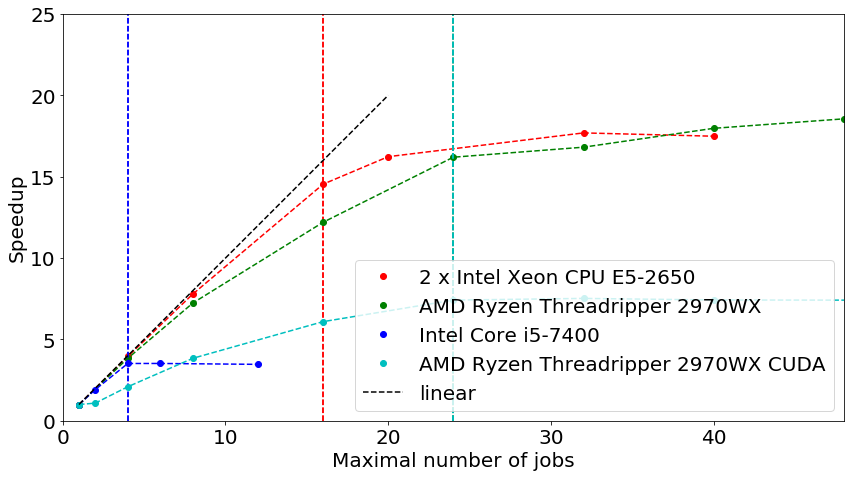

In [53]:
show_speedups('pytorch_asu', 'pytorch_qgpu', 'pytorch_swing', 'pytorch_qgpu_cuda',
                ylim=dict(top=25, bottom=0), xlim=dict(left=0, right=48))

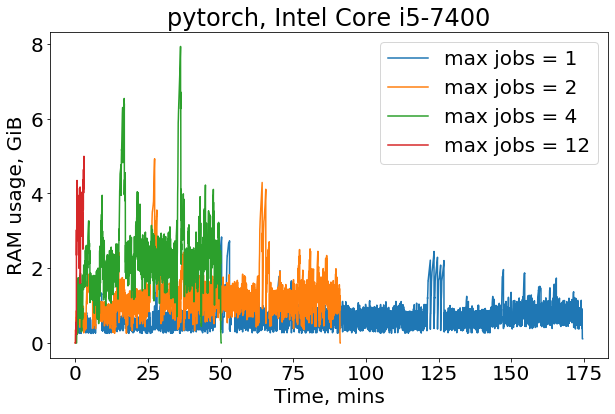

In [493]:
show_memusage([1, 2, 4, 8, 12, 16, 24, 32, 40, 48, 56, 72], 'pytorch_swing')

## Use case: OmnisciDB



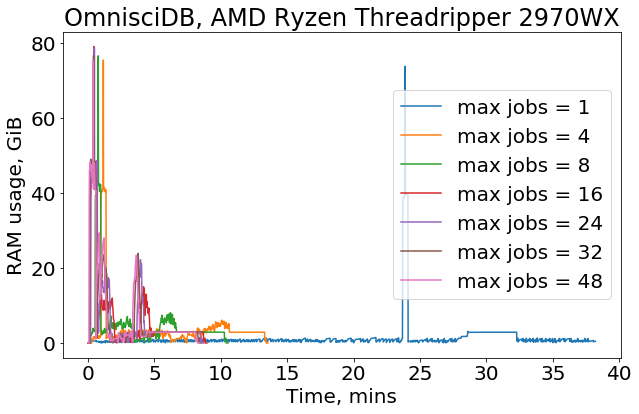

In [75]:
show_memusage([1, 4, 8, 16, 24, 32, 48], 'omniscidb')

Note: the high memory usage (>70 GB) peak is due to `java install ...`.

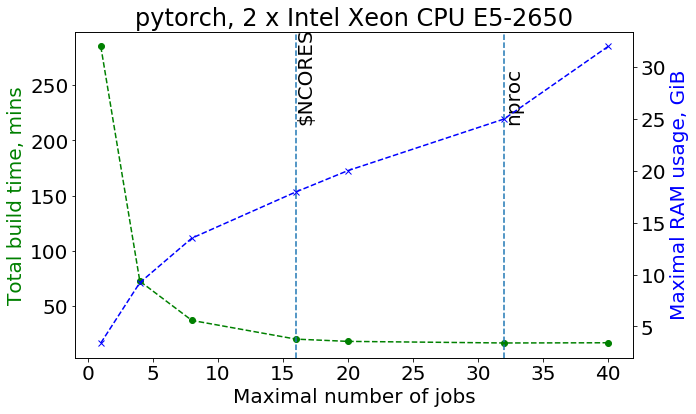

In [76]:
show_build_time('pytorch_asu')